In [1]:
from pytorch_pretrained_vit import ViT
from Image_Encoding import Image_Encoding
from torchvision import transforms
from EEG_Image_Dataset import *
from torch import nn
import torch
import numpy as np
import glob
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from pytorch_pretrained_vit import ViT
import pickle
import torch.nn.functional as F
import cv2
import sys
import os
import tqdm
import random
import math
from torch_intermediate_layer_getter import IntermediateLayerGetter as MidGetter
import time
import torch; torch.utils.backcompat.broadcast_warning.enabled = True
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim
import torch.backends.cudnn as cudnn; cudnn.benchmark = True
import numpy as np
import models
import importlib
import argparse
import matplotlib.pyplot as plt
import time

In [2]:
parser = argparse.ArgumentParser(description="Template")
### BLOCK DESIGN ###
#Data
#parser.add_argument('-ed', '--eeg-dataset', default=r"data\block\eeg_55_95_std.pth", help="EEG dataset path") #55-95Hz
parser.add_argument('-ed', '--eeg-dataset', default=r"/users/sbr/data/eeg_55_95_std.pth", help="EEG dataset path") #5-95Hz
#parser.add_argument('-ed', '--eeg-dataset', default=r"data\block\eeg_14_70_std.pth", help="EEG dataset path") #14-70Hz
#Splits
parser.add_argument('-sp', '--splits-path', default=r"/users/sbr/data/block_splits_by_image_all.pth", help="splits path") #All subjects
#parser.add_argument('-sp', '--splits-path', default=r"data\block\block_splits_by_image_single.pth", help="splits path") #Single subject
### BLOCK DESIGN ###

parser.add_argument('-sn', '--split-num', default=0, type=int, help="split number") #leave this always to zero.

#Subject selecting
parser.add_argument('-sub','--subject', default=0   , type=int, help="choose a subject from 1 to 6, default is 0 (all subjects)")

#Time options: select from 20 to 460 samples from EEG data
parser.add_argument('-tl', '--time_low', default=20, type=float, help="lowest time value")
parser.add_argument('-th', '--time_high', default=460,  type=float, help="highest time value")

# Model type/options
parser.add_argument('-mt','--model_type', default='EEGChannelNet', help='specify which generator should be used: lstm|EEGChannelNet')
# It is possible to test out multiple deep classifiers:
# - lstm is the model described in the paper "Deep Learning Human Mind for Automated Visual Classification”, in CVPR 2017
# - model10 is the model described in the paper "Decoding brain representations by multimodal learning of neural activity and visual features", TPAMI 2020
parser.add_argument('-mp','--model_params', default='', nargs='*', help='list of key=value pairs of model options')
parser.add_argument('--pretrained_net', default='', help="path to pre-trained net (to continue training)")

# Training options
parser.add_argument("-b", "--batch_size", default=32, type=int, help="batch size")
parser.add_argument('-o', '--optim', default="Adam", help="optimizer")
parser.add_argument('-lr', '--learning-rate', default=0.001, type=float, help="learning rate")
parser.add_argument('-lrdb', '--learning-rate-decay-by', default=0.5, type=float, help="learning rate decay factor")
parser.add_argument('-lrde', '--learning-rate-decay-every', default=10, type=int, help="learning rate decay period")
parser.add_argument('-dw', '--data-workers', default=4, type=int, help="data loading workers")
parser.add_argument('-e', '--epochs', default=100, type=int, help="training epochs")

# Save options
parser.add_argument('-sc', '--saveCheck', default=5, type=int, help="learning rate")

# Backend options
parser.add_argument('--no-cuda', default=False, help="disable CUDA", action="store_true")

# Parse arguments
opt, _ = parser.parse_known_args()
print(opt)

Namespace(batch_size=32, data_workers=4, eeg_dataset='/users/sbr/data/eeg_55_95_std.pth', epochs=100, learning_rate=0.001, learning_rate_decay_by=0.5, learning_rate_decay_every=10, model_params='', model_type='EEGChannelNet', no_cuda=False, optim='Adam', pretrained_net='', saveCheck=5, split_num=0, splits_path='/users/sbr/data/block_splits_by_image_all.pth', subject=0, time_high=460, time_low=20)


In [3]:
with open('/users/sbr/data/Image_data/image_path.pkl', 'rb') as f:
    image_path = pickle.load(f)
    
loaders = {split: DataLoader(Splitter(EEG_Image_Dataset(opt.eeg_dataset, image_path, split), split_path = opt.splits_path, split_num = opt.split_num, split_name = split), batch_size = 16, drop_last = True, shuffle = True) for split in ["train", "val", "test"]}

In [4]:
class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=512,
        dropout=0.1
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)
    
    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

In [6]:
EEG_Encoder = torch.load('/users/sbr/code/Image/EEGChannelNet__subject0_epoch_40.pth') 
"""for param in EEG_Encoder.parameters():
    param.requires_grad = False

EEG_Encoder.embedding.requires_grad = True
EEG_Encoder.classifier.requires_grad = True"""
EEG_Encoder.cuda()
print('Copied to CUDA')

Copied to CUDA


In [7]:
class CLIPModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.image_encoder = mid_getter
        self.EEG_encoder = EEG_Encoder
        self.image_projection = ProjectionHead(embedding_dim=768)
        self.EEG_projection = ProjectionHead(embedding_dim=1000)

    def forward(self, EEG, image, label, image_label):
        image_features, image_class = self.image_encoder(image)
        image_features = image_features['norm'][:,0]
        
        EEG_features, EEG_class = self.EEG_encoder(EEG)
        image_embeddings = self.image_projection(image_features)
        EEG_embeddings = self.EEG_projection(EEG_features)

        logits = (EEG_embeddings @ image_embeddings.T)
        images_similarity = image_embeddings @ image_embeddings.T
        EEG_similarity = EEG_embeddings @ EEG_embeddings.T
        
        targets = F.softmax((images_similarity + EEG_similarity) / 2, dim=-1)
        
        EEG_s_loss = cross_entropy(logits, targets, reduction='none')
        image_s_loss = cross_entropy(logits.T, targets.T, reduction='none')
        CLIP_loss =  (image_s_loss + EEG_s_loss) / 2.0
        
        image_c_loss = F.cross_entropy(image_class, label)
        EEG_c_loss = F.cross_entropy(EEG_class, label)
        
        loss = CLIP_loss + ((image_c_loss + EEG_c_loss) / 2.0) * 0.1
        
        return loss.mean()


def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

In [8]:
#initialize training,validation, test losses and accuracy list

clip = CLIPModel()
clip.cuda()

losses_per_epoch={"train":[], "val":[],"test":[]}
eeg_accuracies_per_epoch={"train":[],"val":[],"test":[]}
image_accuracies_per_epoch={"train":[],"val":[],"test":[]}

optimizer = torch.optim.Adam([
                {'params': clip.image_projection.parameters()},
                {'params': clip.EEG_projection.parameters()},
                {'params': clip.EEG_encoder.parameters(), 'lr': 1e-5}], lr=0.001)
best_accuracy = 0
best_accuracy_val = 0
best_epoch = 0
# Start training

predicted_labels = [] 
correct_labels = []

for epoch in range(1, 50+1):
    start = time.time()
    losses = {"train": 0, "val": 0, "test": 0}
    eeg_accuracies = {"train": 0, "val": 0, "test": 0}
    image_accuracies = {"train": 0, "val": 0, "test": 0}
    
    counts = {"train": 0, "val": 0, "test": 0}

    for split in ("train", "val", "test"):

        if split == "train":
            clip.train()
            torch.set_grad_enabled(True)
        else:
            clip.eval()
            torch.set_grad_enabled(False)
        train_gen = tqdm.tqdm(loaders[split])
        for i, (EEG, image, label, image_label) in enumerate(train_gen):
        
            EEG = EEG.cuda()
            image = image.cuda()
            label = label.cuda()
            image_label = image_label.cuda()
            
            loss = clip(EEG, image, label, image_label)
            
            # Compute loss
            losses[split] += loss.item()
            # Compute accuracy
            with torch.no_grad():
                _, EEG_output = EEG_Encoder(EEG)
            _,pred = EEG_output.data.max(1)
            correct = pred.eq(label.data).sum().item()
            accuracy = correct/EEG.data.size(0)   
            eeg_accuracies[split] += accuracy
            counts[split] += 1
            
            # Backward and optimize
            if split == "train":
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

    if eeg_accuracies["val"]/counts["val"] >= best_accuracy_val:
        best_accuracy_val = eeg_accuracies["val"]/counts["val"]
        best_accuracy = eeg_accuracies["test"]/counts["test"] 
        best_epoch = epoch
    
    print('Time for Epoch {0}: {1:.2f}'.format(epoch, time.time() - start))
    print("Epoch {0}:\n TOTAL: TrL(CLIP)={1:.4f}, VL(CLIP)={3:.4f}, TeL(CLIP)={5:.4f} \n EEG: TrA={2:.4f}, VA={4:.4f}, TeA={6:.4f} \n  TeA at max VA = {7:.4f} at epoch {8:d}".format(epoch,
                                                                                                         losses["train"]/counts["train"],
                                                                                                         eeg_accuracies["train"]/counts["train"],
                                                                                                         losses["val"]/counts["val"],
                                                                                                         eeg_accuracies["val"]/counts["val"],
                                                                                                         losses["test"]/counts["test"],
                                                                                                         eeg_accuracies["test"]/counts["test"],
                                                                                                         best_accuracy, 
                                                                                                         best_epoch))
    
    losses_per_epoch['train'].append(losses["train"]/counts["train"])
    losses_per_epoch['val'].append(losses["val"]/counts["val"])
    losses_per_epoch['test'].append(losses["test"]/counts["test"])
    eeg_accuracies_per_epoch['train'].append(eeg_accuracies["train"]/counts["train"])
    eeg_accuracies_per_epoch['val'].append(eeg_accuracies["val"]/counts["val"])
    eeg_accuracies_per_epoch['test'].append(eeg_accuracies["test"]/counts["test"])

    if epoch%5 == 0:
        torch.save(clip, '%s_epoch_%d.pth' % ('CLIP', epoch))

100%|█████████████████████████████████████████| 124/124 [00:55<00:00,  2.24it/s]


Time for Epoch 1: 419.76
Epoch 1:
 TOTAL: TrL(CLIP)=8.0482, VL(CLIP)=2.7925, TeL(CLIP)=2.9434 
 EEG: TrA=0.6048, VA=0.5161, TeA=0.5035 
  TeA at max VA = 0.5161 at epoch 1


100%|█████████████████████████████████████████| 124/124 [00:57<00:00,  2.17it/s]


Time for Epoch 2: 419.07
Epoch 2:
 TOTAL: TrL(CLIP)=2.4430, VL(CLIP)=2.1702, TeL(CLIP)=2.2128 
 EEG: TrA=0.6166, VA=0.5207, TeA=0.5015 
  TeA at max VA = 0.5207 at epoch 2


100%|█████████████████████████████████████████| 124/124 [00:55<00:00,  2.22it/s]


Time for Epoch 3: 424.60
Epoch 3:
 TOTAL: TrL(CLIP)=1.9837, VL(CLIP)=1.9191, TeL(CLIP)=2.0200 
 EEG: TrA=0.6201, VA=0.5161, TeA=0.4990 
  TeA at max VA = 0.5207 at epoch 2


100%|█████████████████████████████████████████| 124/124 [00:55<00:00,  2.22it/s]


Time for Epoch 4: 417.55
Epoch 4:
 TOTAL: TrL(CLIP)=1.7826, VL(CLIP)=1.7953, TeL(CLIP)=1.8854 
 EEG: TrA=0.6322, VA=0.5237, TeA=0.5050 
  TeA at max VA = 0.5237 at epoch 4


100%|█████████████████████████████████████████| 124/124 [00:57<00:00,  2.17it/s]


Time for Epoch 5: 428.63
Epoch 5:
 TOTAL: TrL(CLIP)=1.6863, VL(CLIP)=1.8016, TeL(CLIP)=1.8337 
 EEG: TrA=0.6376, VA=0.5212, TeA=0.5035 
  TeA at max VA = 0.5237 at epoch 4


100%|█████████████████████████████████████████| 124/124 [01:04<00:00,  1.92it/s]


Time for Epoch 6: 458.19
Epoch 6:
 TOTAL: TrL(CLIP)=1.6379, VL(CLIP)=1.7820, TeL(CLIP)=1.8206 
 EEG: TrA=0.6351, VA=0.5333, TeA=0.5035 
  TeA at max VA = 0.5333 at epoch 6


100%|█████████████████████████████████████████| 124/124 [01:00<00:00,  2.07it/s]


Time for Epoch 7: 443.06
Epoch 7:
 TOTAL: TrL(CLIP)=1.5846, VL(CLIP)=1.7203, TeL(CLIP)=1.7844 
 EEG: TrA=0.6442, VA=0.5343, TeA=0.5060 
  TeA at max VA = 0.5343 at epoch 7


100%|█████████████████████████████████████████| 124/124 [00:58<00:00,  2.13it/s]


Time for Epoch 8: 453.70
Epoch 8:
 TOTAL: TrL(CLIP)=1.5375, VL(CLIP)=1.7495, TeL(CLIP)=1.7626 
 EEG: TrA=0.6455, VA=0.5292, TeA=0.5111 
  TeA at max VA = 0.5343 at epoch 7


100%|█████████████████████████████████████████| 124/124 [00:58<00:00,  2.11it/s]


Time for Epoch 9: 443.45
Epoch 9:
 TOTAL: TrL(CLIP)=1.5095, VL(CLIP)=1.7179, TeL(CLIP)=1.7850 
 EEG: TrA=0.6434, VA=0.5287, TeA=0.5141 
  TeA at max VA = 0.5343 at epoch 7


100%|█████████████████████████████████████████| 124/124 [00:57<00:00,  2.15it/s]


Time for Epoch 10: 429.17
Epoch 10:
 TOTAL: TrL(CLIP)=1.5023, VL(CLIP)=1.7549, TeL(CLIP)=1.8020 
 EEG: TrA=0.6537, VA=0.5318, TeA=0.5161 
  TeA at max VA = 0.5343 at epoch 7


100%|█████████████████████████████████████████| 124/124 [00:57<00:00,  2.17it/s]


Time for Epoch 11: 429.63
Epoch 11:
 TOTAL: TrL(CLIP)=1.4907, VL(CLIP)=1.7225, TeL(CLIP)=1.7395 
 EEG: TrA=0.6444, VA=0.5328, TeA=0.5121 
  TeA at max VA = 0.5343 at epoch 7


100%|█████████████████████████████████████████| 124/124 [00:58<00:00,  2.13it/s]


Time for Epoch 12: 424.53
Epoch 12:
 TOTAL: TrL(CLIP)=1.4627, VL(CLIP)=1.7552, TeL(CLIP)=1.7514 
 EEG: TrA=0.6426, VA=0.5307, TeA=0.5096 
  TeA at max VA = 0.5343 at epoch 7


100%|█████████████████████████████████████████| 124/124 [00:56<00:00,  2.19it/s]


Time for Epoch 13: 433.08
Epoch 13:
 TOTAL: TrL(CLIP)=1.4614, VL(CLIP)=1.7247, TeL(CLIP)=1.7397 
 EEG: TrA=0.6543, VA=0.5312, TeA=0.5141 
  TeA at max VA = 0.5343 at epoch 7


100%|█████████████████████████████████████████| 124/124 [00:56<00:00,  2.20it/s]


Time for Epoch 14: 429.53
Epoch 14:
 TOTAL: TrL(CLIP)=1.4395, VL(CLIP)=1.7521, TeL(CLIP)=1.7711 
 EEG: TrA=0.6528, VA=0.5343, TeA=0.5146 
  TeA at max VA = 0.5343 at epoch 14


100%|█████████████████████████████████████████| 124/124 [00:54<00:00,  2.27it/s]


Time for Epoch 15: 418.88
Epoch 15:
 TOTAL: TrL(CLIP)=1.4382, VL(CLIP)=1.6375, TeL(CLIP)=1.6967 
 EEG: TrA=0.6488, VA=0.5403, TeA=0.5212 
  TeA at max VA = 0.5403 at epoch 15


100%|█████████████████████████████████████████| 124/124 [00:55<00:00,  2.23it/s]


Time for Epoch 16: 422.53
Epoch 16:
 TOTAL: TrL(CLIP)=1.4368, VL(CLIP)=1.6974, TeL(CLIP)=1.7759 
 EEG: TrA=0.6527, VA=0.5393, TeA=0.5141 
  TeA at max VA = 0.5403 at epoch 15


100%|█████████████████████████████████████████| 124/124 [00:54<00:00,  2.27it/s]


Time for Epoch 17: 416.70
Epoch 17:
 TOTAL: TrL(CLIP)=1.4229, VL(CLIP)=1.7021, TeL(CLIP)=1.7153 
 EEG: TrA=0.6611, VA=0.5353, TeA=0.5141 
  TeA at max VA = 0.5403 at epoch 15


100%|█████████████████████████████████████████| 124/124 [00:56<00:00,  2.18it/s]


Time for Epoch 18: 423.39
Epoch 18:
 TOTAL: TrL(CLIP)=1.4035, VL(CLIP)=1.6672, TeL(CLIP)=1.7115 
 EEG: TrA=0.6615, VA=0.5413, TeA=0.5156 
  TeA at max VA = 0.5413 at epoch 18


100%|█████████████████████████████████████████| 124/124 [00:54<00:00,  2.26it/s]


Time for Epoch 19: 424.41
Epoch 19:
 TOTAL: TrL(CLIP)=1.4127, VL(CLIP)=1.7090, TeL(CLIP)=1.7036 
 EEG: TrA=0.6540, VA=0.5408, TeA=0.5171 
  TeA at max VA = 0.5413 at epoch 18


100%|█████████████████████████████████████████| 124/124 [00:56<00:00,  2.21it/s]


Time for Epoch 20: 415.97
Epoch 20:
 TOTAL: TrL(CLIP)=1.3868, VL(CLIP)=1.6740, TeL(CLIP)=1.7125 
 EEG: TrA=0.6558, VA=0.5373, TeA=0.5161 
  TeA at max VA = 0.5413 at epoch 18


  2%|▉                                         | 11/497 [00:08<06:18,  1.28it/s]


KeyboardInterrupt: 

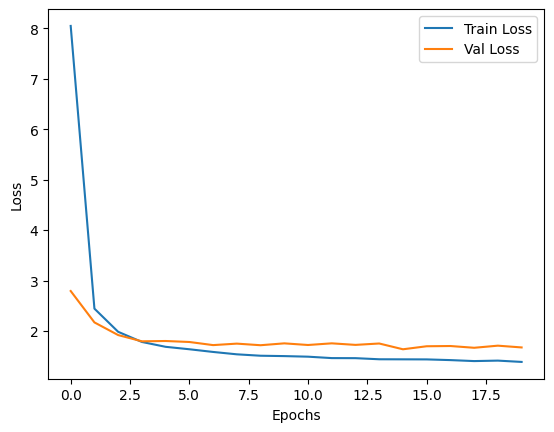

In [11]:
plt.figure()
plt.plot(losses_per_epoch['train'])
plt.plot(losses_per_epoch['val'])
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend(['Train Loss', 'Val Loss'])
plt.savefig('CLIP_EEG_Encoding_loss.png')
plt.show()

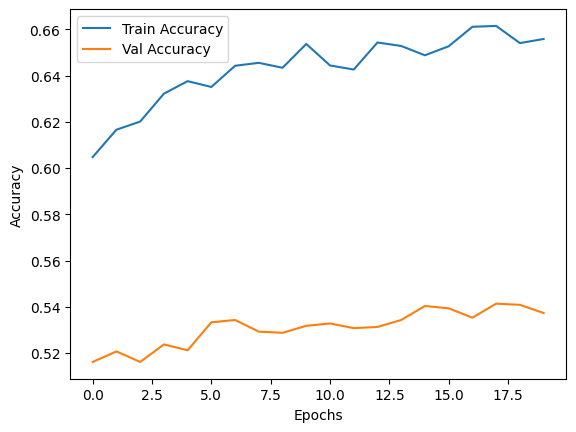

In [13]:
plt.figure()
plt.plot(eeg_accuracies_per_epoch['train'])
plt.plot(eeg_accuracies_per_epoch['val'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend(['Train Accuracy', 'Val Accuracy'])
plt.savefig('CLIP_EEG_Encoding_Accuracy.png')
plt.show()